Includes:

In [1]:
import seaborn as sn
import os
import matplotlib.pyplot as plt
from data_paths import get_file_paths_ordered
from pre_process import *
from models import *

Number of speakers and the percentage of the available samples to use to consider:

In [2]:
num_speakers = 8
dataset_percentage = 0.45
segmentLength=1024

Read data:

Total number of speakers in the original dataset: 1251


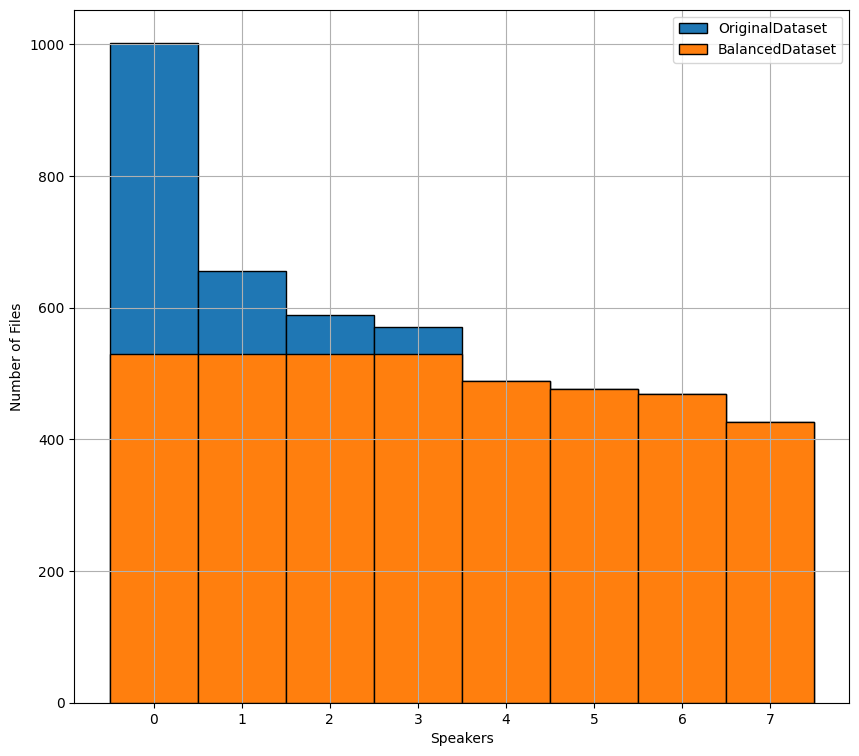

Visualization of the samples ...


100%|██████████| 3975/3975 [00:00<00:00, 12071.45it/s]


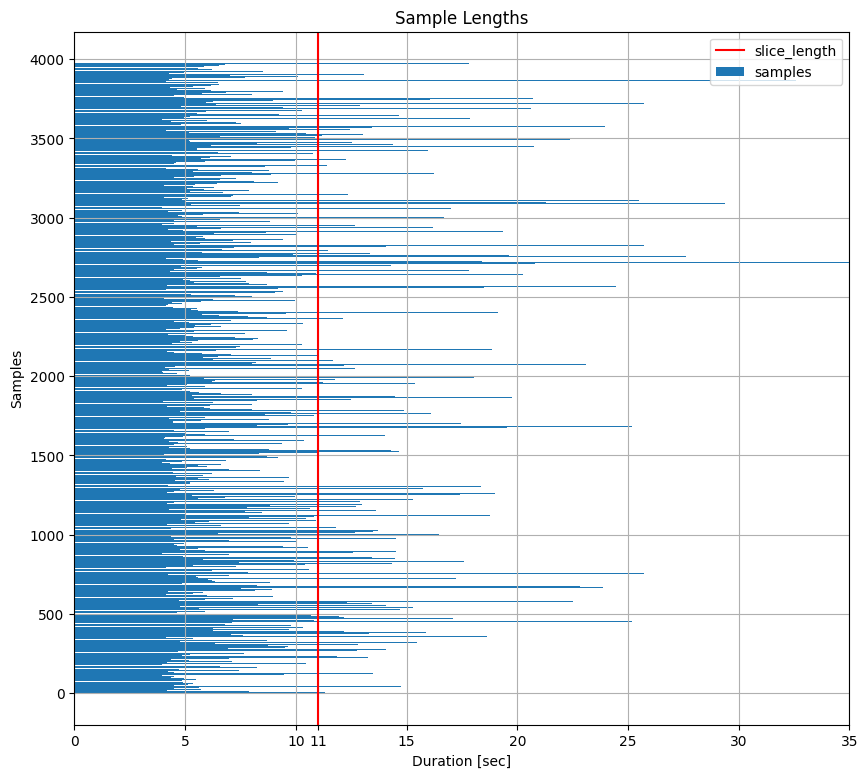

100%|██████████| 795/795 [00:00<00:00, 2725.70it/s]


In [3]:
paths_train, paths_test, y_train_l, y_test_l, all_paths_l = \
    get_file_paths_ordered(num_speaker=num_speakers, test_ratio=0.2, balanced_dataset=True, plot_data=True)

slice_len = choose_tot_slice_len(paths=all_paths_l, visualize=True)

f_s, x_train, y_train, x_test, y_test = get_data_tensors(paths_train=paths_train, paths_test=paths_test, 
                                                         y_train_l=y_train_l, y_test_l=y_test_l,
                                                         tot_slice_len=slice_len,
                                                         used_train_sz_rat=dataset_percentage, 
                                                         used_test_sz_rat=1.,
                                                         segmentLength=segmentLength)

@TODO play some of the speakers as an example

Pre-Processing:

In [4]:
f_low=80.
f_up=7600.
num_mel_bins=80
num_mfcc=13

x_train_mfcc = compute_mfccs(x_train, frame_length=segmentLength, sample_rate=f_s, 
                             lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                             num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)
x_test_mfcc  = compute_mfccs(x_test, frame_length=segmentLength, sample_rate=f_s, 
                             lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                             num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)

Define the Model:

In [5]:
model_idx = 0
input_shape = x_train_mfcc.shape
model = get_model(input_shape=input_shape, nb_classes=num_speakers, model_idx=model_idx)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (1431, 171, 13, 1)       3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (1431, 171, 13, 3)        30        
                                                                 
 batch_normalization (BatchN  (1431, 171, 13, 3)       12        
 ormalization)                                                   
                                                                 
 activation (Activation)     (1431, 171, 13, 3)        0         
                                                                 
 conv2d_1 (Conv2D)           (1431, 86, 7, 16)         448       
                                                                 
 batch_normalization_1 (Batc  (1431, 86, 7, 16)        6

Define learning parameters:

In [6]:
batchSize = 8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 40 # nb of back propagations
loss_fct = 'sparse_categorical_crossentropy'

Compile the model and Fit the Data:

In [7]:
model.compile(loss=loss_fct, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_keras = model.fit(x=x_train_mfcc, y=y_train, batch_size=batchSize, epochs=epochs, validation_split=0.2)

Epoch 1/40
143/143 [==============================] - 2s 5ms/step - loss: 1.8024 - accuracy: 0.2902 - val_loss: 2.0226 - val_accuracy: 0.1603
Epoch 2/40
143/143 [==============================] - 0s 3ms/step - loss: 1.4767 - accuracy: 0.4790 - val_loss: 2.8778 - val_accuracy: 0.1359
Epoch 3/40
143/143 [==============================] - 1s 4ms/step - loss: 1.1699 - accuracy: 0.5997 - val_loss: 2.6651 - val_accuracy: 0.1742
Epoch 4/40
143/143 [==============================] - 1s 4ms/step - loss: 0.9177 - accuracy: 0.6862 - val_loss: 2.5103 - val_accuracy: 0.2056
Epoch 5/40
143/143 [==============================] - 1s 4ms/step - loss: 0.7164 - accuracy: 0.7552 - val_loss: 1.3769 - val_accuracy: 0.4948
Epoch 6/40
143/143 [==============================] - 1s 4ms/step - loss: 0.6323 - accuracy: 0.7823 - val_loss: 0.6898 - val_accuracy: 0.7735
Epoch 7/40
143/143 [==============================] - 1s 4ms/step - loss: 0.6207 - accuracy: 0.7823 - val_loss: 1.9217 - val_accuracy: 0.3693
Epoch 

Evaluate the performance on the test set:

In [8]:
y_pred = model.predict(x_test_mfcc)

test_loss, test_acc = model.evaluate(x_test_mfcc,  y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

25/25 [==============================] - 0s 2ms/step
25/25 - 0s - loss: 0.7317 - accuracy: 0.7862 - 54ms/epoch - 2ms/step
Test accuracy: 0.7861635088920593
Test loss: 0.7316678166389465


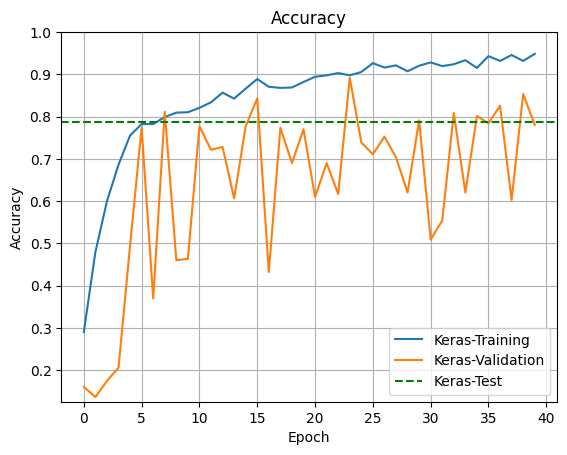

In [9]:
plt.figure()
plt.plot(history_keras.history['accuracy'], label='Keras-Training')
plt.plot(history_keras.history['val_accuracy'], label='Keras-Validation')
plt.axhline(y=test_acc, xmin=0, xmax=epochs, linestyle='--', color='g', label='Keras-Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([1/num_speakers, 1])
plt.legend(loc='lower right')
plt.grid()
plt.title("Accuracy")
plt.show()


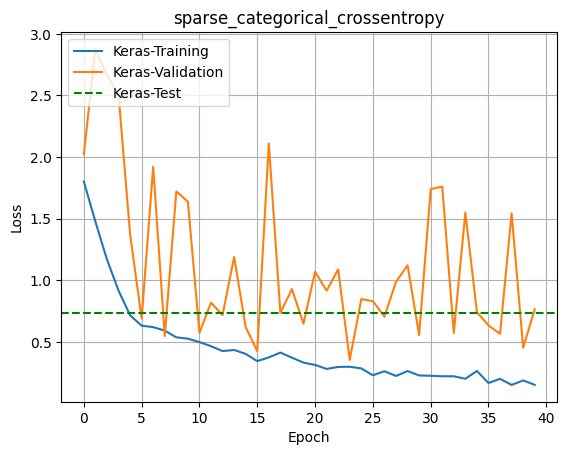

In [10]:
plt.figure()
plt.plot(history_keras.history['loss'], label='Keras-Training')
plt.plot(history_keras.history['val_loss'], label='Keras-Validation')
plt.axhline(y=test_loss, xmin=0, xmax=epochs, linestyle='--', color='g', label='Keras-Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([1/num_speakers, 1])
plt.legend(loc='upper left')
plt.grid()
plt.title(loss_fct)
plt.show()

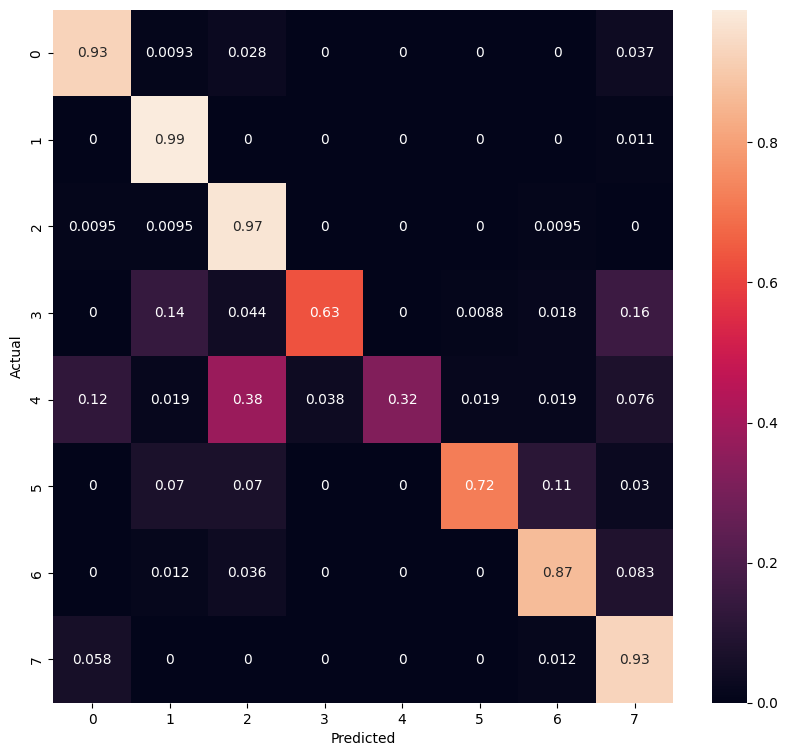

In [11]:
from sklearn.metrics import confusion_matrix

y_pred_hard = np.argmax(y_pred, axis=1)
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, y_pred_hard, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Saving parameters

In [12]:
model_name = 'speaker_det'

path_keras_model = '../Models/KerasModels/'
path_tf_lite_nq = '../Models/TFLiteModelsNonQuantized/'
path_tf_lite_q = '../Models/TFLiteModelsQuantized/'

# Create the directories
paths = [path_keras_model, path_tf_lite_nq, path_tf_lite_q]
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

Save the Keras Model

In [13]:
model_name = 'speaker_det' + str(model_idx)
model.save(path_keras_model + 'keras_' + model_name + '.h5')

TF Lite Conversion and Quantization:

INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmp5lluth2j\assets


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmp5lluth2j\assets


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmpesyr58lf\assets


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmpesyr58lf\assets
c:\Users\kerem\anaconda3\envs\ml_mcu_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


HDF5 Model size without quantization: 334 KB
TFLite Model size without quantization: 28 KB

Reduction in model size from Keras to TFLite by a factor of 11.923398
Quantized TFLite Model size: 28 KB

Reduction in model size from Keras to TFLiteQuantized by a factor of 11.923398


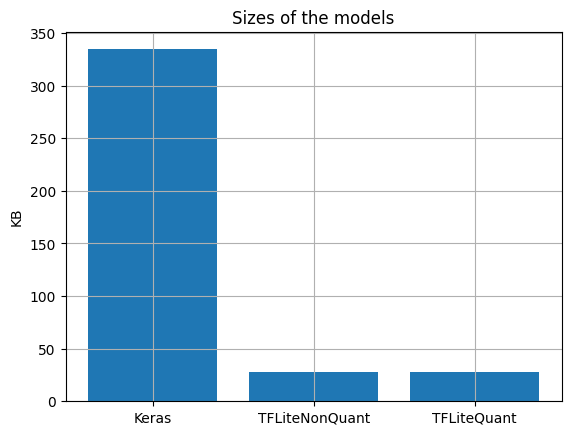

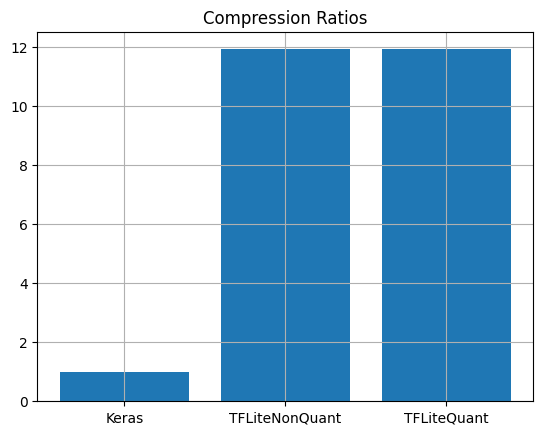

In [14]:
from tf_lite_conversion import *

convert_to_tf_lite(model=model, model_name=model_name, 
                   path_keras=path_keras_model, 
                   path_tf_lite_nq=path_tf_lite_nq,
                   train_set=x_test_mfcc,
                   path_tf_lite_q=path_tf_lite_q)

@ TODO verify the above compression ratio, we gained nothing from it ?

Quantization to 8 bits:

In [15]:

convert_to_tf_lite_quantized(model=model, model_name=model_name, 
                             path_tf_lite_q=path_tf_lite_q, train_set=x_test_mfcc)

INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmprtk8a8ub\assets


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmprtk8a8ub\assets
c:\Users\kerem\anaconda3\envs\ml_mcu_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Save the quantized data:

In [16]:
quan_test_dat_path = '../QuantizedTestData/'

# Create the directory
if not os.path.exists(quan_test_dat_path):
    os.makedirs(quan_test_dat_path)
    
# save the test data as numpy arrays
np.save(quan_test_dat_path + 'x_test_voxceleb.npy', tf.cast(x_test_mfcc, dtype=tf.uint8))#.astype(np.uint8))
np.save(quan_test_dat_path + 'y_test_voxceleb.npy', y_test)

@TODO Listen some of the quantized examples and compare them to the on quantized versions

Performance evaluation:

In [30]:
# Test the model using the tflite interpreter with quantization
# interpreter = tf.lite.Interpreter(model_path=path_tf_lite_q+"tf_lite_speaker_det0_quant.tflite")
interpreter = tf.lite.Interpreter(model_path=path_tf_lite_nq+"tf_lite_speaker_det0_no_quant.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# print some information about the input and output tensors
print("Input shape is {} and of type {}".format(input_details[0]['shape'], input_details[0]['dtype']))
print("Output shape is {} and of type {}".format(output_details[0]['shape'], output_details[0]['dtype']))

Input shape is [  1 171  13   1] and of type <class 'numpy.int8'>
Output shape is [1 8] and of type <class 'numpy.int8'>


In [31]:
input_data = tf.cast(tf.cast(x_test_mfcc, tf.int32)-128, tf.int8)
input_shape = input_details[0]['shape']
interpreter.resize_tensor_input(input_details[0]['index'], input_data.shape)
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [32]:
from sklearn.metrics import accuracy_score
print("Accuracy of quantized model is: ", accuracy_score(y_test, np.argmax(output_data, axis=1)))

Accuracy of quantized model is:  0.13081761006289308


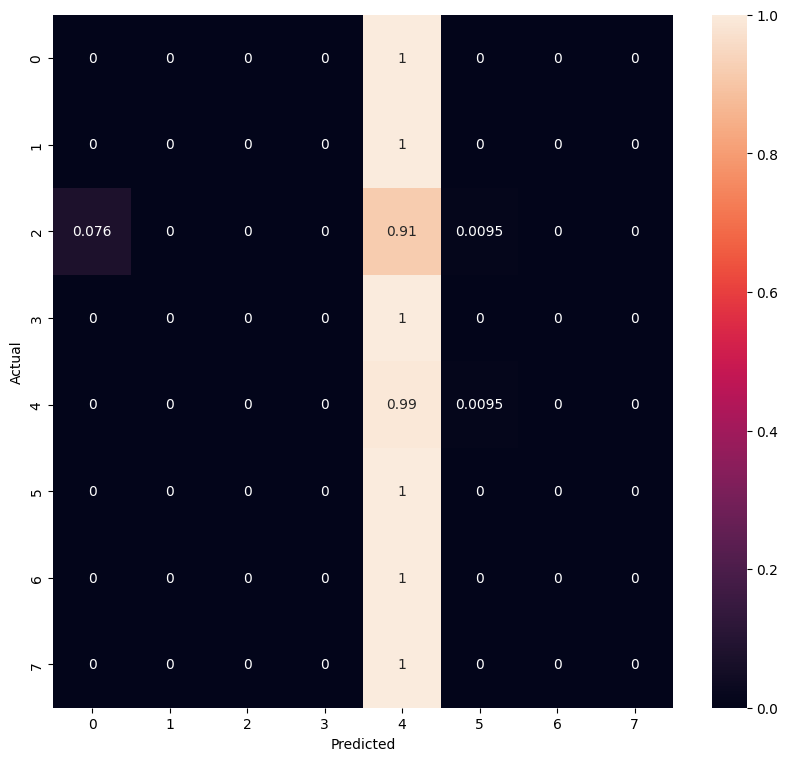

In [28]:
plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, np.argmax(output_data, axis=1), 
                      normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()